# POROČILO: Statistika okoliščin prometnih nesreč v Sloveniji v letu 2021 in 2022

### Projektna naloga pri podatkovnemu rudarjenju 2023

Avtorji:
Nina Plevnik, Jernej Ivančič, Nejc Brnelič, Tilen Smrdel, Miha Ciglar

#### Problem: Prometne nesreče so velik povzročitelj fizičnih poškodb in smrti v Sloveniji.

Podatki: Za bazo podatkov smo uporabili analizo prometne varnosti za leto 2022. V bazi so združeni vsi podatki o prometnih nesrečah in udeleženih osebah, ki so nastopale kot povzročitelj ali poškodovanec/žrtev. Baza zajema vse prometne nesreče, ki si jih je ogledala in analizirala policija. V bazi podatkov smo zasledili tudi nekaj napak pri vnosu, in sicer pri formatiranju določenih podatkov. Celotno ločevanje podatkov in popravljanje formatiranja podatkov smo opravili pred analizami in vizualizacijami.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler


cas = pd.read_csv('./baze/manjse/Cas.csv')
cesta = pd.read_csv('./baze/manjse/Cesta.csv')
faktor_cest = pd.read_csv('./baze/manjse/FaktorCest.csv')
faktor_oseb = pd.read_csv('./baze/manjse/FaktorOseb.csv')
koordinate = pd.read_csv('./baze/manjse/Koordinate.csv')
kraj = pd.read_csv('./baze/manjse/Kraj.csv')
nesreca = pd.read_csv('./baze/manjse/Nesreca.csv')
osebe = pd.read_csv('./baze/manjse/Osebe.csv')
splosno = pd.read_csv('./baze/manjse/Splosno.csv')

Vprašanja / glavni cilji:

### **1. vprašanje: Kako oseba vpliva na nesrečo?** 

Ali izkušnje na cesti oz. obdobje imetja izpita vpliva na število povzročenih nesreč?

In [20]:
mask_povzrocitelj = (osebe['Povzrocitelj'] == 'POVZROČITELJ') & (osebe['MeseciIzpita'] > 0) & (osebe['MeseciIzpita'] < 1000)
povzrocitelj = osebe[mask_povzrocitelj]

mask_mladi_voznik = (povzrocitelj['MeseciIzpita'] > 0) & (povzrocitelj['MeseciIzpita'] <= 24)
mladi_voznik = povzrocitelj[mask_mladi_voznik]

mask_stari_voznik = (povzrocitelj['Starost'] > 70) & (povzrocitelj['MeseciIzpita'] > 0) & (povzrocitelj['MeseciIzpita'] > 24)
stari_voznik = povzrocitelj[mask_stari_voznik]

# print(f"Povzročitelj nesreče je maldi voznik: {len(mladi_voznik)}")
# print(f"Povzročitelj nesreče je starostnik: {len(stari_voznik)}")

stat_ml= len(mladi_voznik)/len((povzrocitelj['MeseciIzpita'] > 0))*100
stat_st= len(stari_voznik)/len((povzrocitelj['MeseciIzpita'] > 0))*100

print(f"Procent nesreč, ki jih je povzročil mladi voznik: {stat_ml:.2f}%")
print(f"Procent nesreč, ki jih je povzročil stari voznik: {stat_st:.2f}%")

Procent nesreč, ki jih je povzročil mladi voznik: 9.38%
Procent nesreč, ki jih je povzročil stari voznik: 10.45%


Ali je bolj izkušen voznik večkrat v nesreči zaradi neprilagojene hitrosti? 

Correlation coefficient: -0.64
P-value: 3.0996105045371644e-68


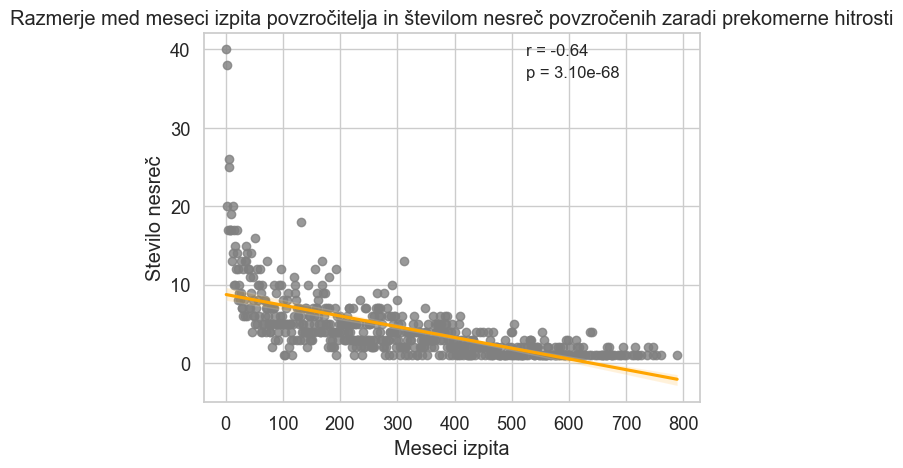

In [21]:
mask_udelezenec = (osebe['Povzrocitelj'] == 'UDELEŽENEC')
udelezenec = osebe[mask_udelezenec]

skupi = pd.merge(povzrocitelj, nesreca, on='ZaporednaStevilkaOsebeVPN')

test = skupi[skupi['VzrokNesrece'].str.contains('NEPRILAGOJENA HITROST')]
meseci_izpita_counts_hitrost = test['MeseciIzpita'].value_counts().sort_index()

# korelacijski koeficient in vrednost-P
corr_coef_h, p_value_h = pearsonr(meseci_izpita_counts_hitrost, meseci_izpita_counts_hitrost.index)
print(f"Correlation coefficient: {corr_coef_h:.2f}")
print('P-value:',p_value_h)

# graf dobljenih rezultatov razmera hitrost in leto izpita
sns.set_style('whitegrid')
sns.regplot(x=meseci_izpita_counts_hitrost.index, y=meseci_izpita_counts_hitrost,scatter_kws={'color': 'grey'}, line_kws={'color': 'orange'})
plt.title('Razmerje med meseci izpita povzročitelja in številom nesreč povzročenih zaradi prekomerne hitrosti')
plt.xlabel('Meseci izpita')
plt.ylabel('Stevilo nesreč')

plt.annotate('r = {:.2f}'.format(corr_coef_h), xy=(0.65, 0.94) , xycoords='axes fraction', fontsize=12)
plt.annotate('p = {:.2e}'.format(p_value_h), xy=(0.65, 0.88) , xycoords='axes fraction', fontsize=12)

plt.show()

Katera skupina večkrat ne upošteva cestnih pravil?

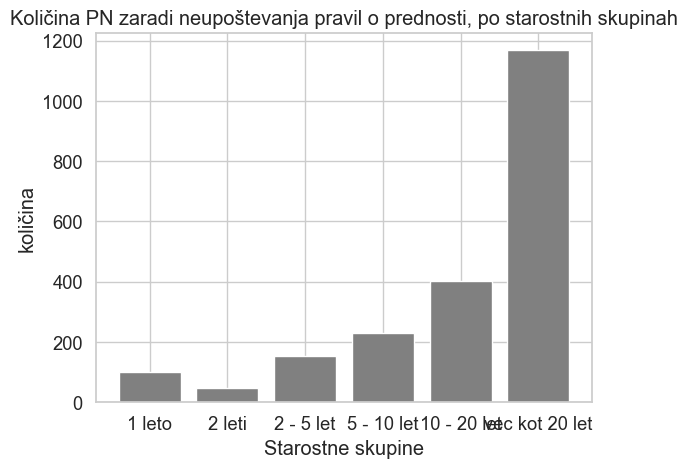

Correlation coefficient: -0.78
P-value: 6.309215766385824e-158


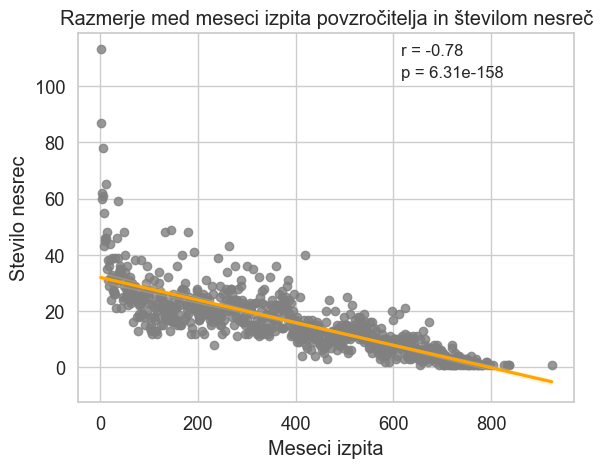

In [22]:
sitnFolk = skupi[skupi['VzrokNesrece'].str.contains('NEUPOŠTEVANJE PRAVIL O PREDNOSTI')]
meseci_izpita_counts_porednezi = sitnFolk['MeseciIzpita'].value_counts().sort_index()

mask_leto_izpita = (sitnFolk['MeseciIzpita'] > 0) & (sitnFolk['MeseciIzpita'] <= 12)
mask_leti2_voznik = (sitnFolk['MeseciIzpita'] > 12) & (sitnFolk['MeseciIzpita'] <= 24)
mask_med_2_in_5 = (sitnFolk['MeseciIzpita'] > 24) & (sitnFolk['MeseciIzpita'] <= 60)
mask_med_5_in_10 = (sitnFolk['MeseciIzpita'] > 50) & (sitnFolk['MeseciIzpita'] <= 120)
mask_med_10_in_20 = (sitnFolk['MeseciIzpita'] > 120) & (sitnFolk['MeseciIzpita'] <= 240)
mask_vec_kot_20 = sitnFolk['MeseciIzpita'] > 240

leto_izpita = sitnFolk[mask_leto_izpita]
leti2_voznik = sitnFolk[mask_leti2_voznik]
med_2_in_5 = sitnFolk[mask_med_2_in_5]
med_5_in_10 = sitnFolk[mask_med_5_in_10]
med_10_in_20 = sitnFolk[mask_med_10_in_20]
vec_kot_20 = sitnFolk[mask_vec_kot_20]

layout = [leto_izpita['MeseciIzpita'].count(), leti2_voznik['MeseciIzpita'].count(), med_2_in_5['MeseciIzpita'].count(), med_5_in_10['MeseciIzpita'].count(), med_10_in_20['MeseciIzpita'].count(), vec_kot_20['MeseciIzpita'].count()]
grupe = ["1 leto", "2 leti", "2 - 5 let", "5 - 10 let", "10 - 20 let", "vec kot 20 let"]

plt.bar(grupe, layout, color='grey')
plt.title('Količina PN zaradi neupoštevanja pravil o prednosti, po starostnih skupinah')
plt.xlabel('Starostne skupine')
plt.ylabel('količina')
plt.show()

meseci_izpita_counts = povzrocitelj['MeseciIzpita'].value_counts().sort_index()

# korelacijski koeficient in vrednost-P
corr_coef, p_value = pearsonr(meseci_izpita_counts, meseci_izpita_counts.index)
print(f"Correlation coefficient: {corr_coef:.2f}")
print('P-value:',p_value)

# graf dobljenih rezultatov
sns.set_style('whitegrid')
sns.regplot(x=meseci_izpita_counts.index, y=meseci_izpita_counts,scatter_kws={'color': 'grey'}, line_kws={'color': 'orange'})
plt.title('Razmerje med meseci izpita povzročitelja in številom nesreč')
plt.xlabel('Meseci izpita')
plt.ylabel('Stevilo nesrec')

plt.annotate('r = {:.2f}'.format(corr_coef), xy=(0.65, 0.94) , xycoords='axes fraction', fontsize=12)
plt.annotate('p = {:.2e}'.format(p_value), xy=(0.65, 0.88) , xycoords='axes fraction', fontsize=12)

plt.show()

Ali mladi udeleženci res povzročijo številčnejše število nesreč kot ostali udeleženci? So to morda starejši?

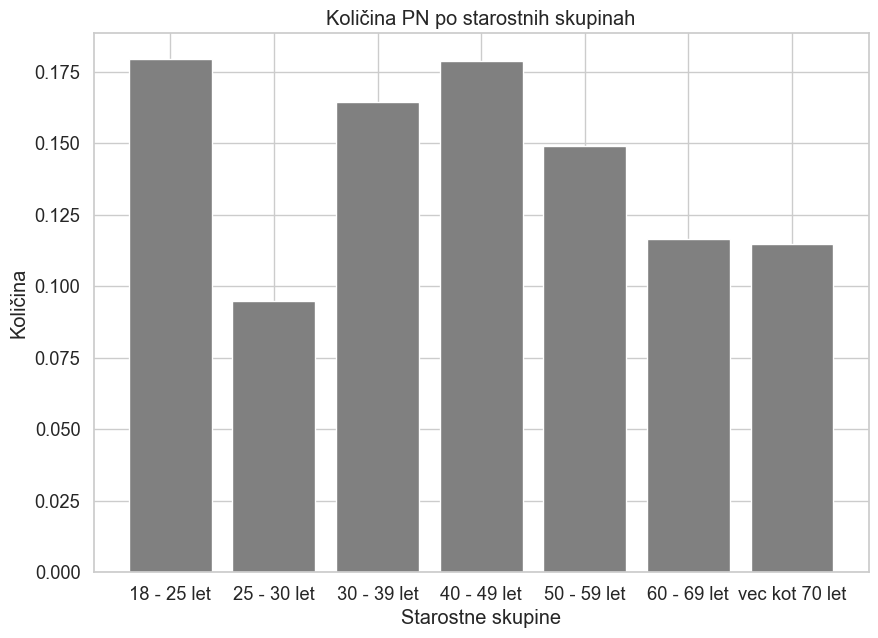

In [23]:
starost_counts_porednezi = skupi['Starost'].value_counts().sort_index()

mask_18_25 = (skupi['Starost'] >= 18) & (skupi['Starost'] <= 25)
mask_25_30 = (skupi['Starost'] > 25) & (skupi['Starost'] <= 30)
mask_30_39 = (skupi['Starost'] > 30) & (skupi['Starost'] <= 39)
mask_40_49 = (skupi['Starost'] > 39) & (skupi['Starost'] <= 49)
mask_50_59 = (skupi['Starost'] > 49) & (skupi['Starost'] <= 59)
mask_60_69 = (skupi['Starost'] > 59) & (skupi['Starost'] <= 69)
mask_vec_kot_70 = (skupi['Starost'] > 69)

e_18_25 = skupi[mask_18_25]
e_25_30 = skupi[mask_25_30]
e_30_39 = skupi[mask_30_39]
e_40_49 = skupi[mask_40_49]
e_50_59 = skupi[mask_50_59]
e_60_69 = skupi[mask_60_69]
vec_ku_70 = skupi[mask_vec_kot_70]

starSkupine = [
    e_18_25['Starost'].count() / len(skupi),
    e_25_30['Starost'].count() / len(skupi),
    e_30_39['Starost'].count() / len(skupi),
    e_40_49['Starost'].count() / len(skupi),
    e_50_59['Starost'].count() / len(skupi),
    e_60_69['Starost'].count() / len(skupi),
    vec_ku_70['Starost'].count() / len(skupi)
]# print(starSkupine)
StarLabli = ["18 - 25 let", "25 - 30 let", "30 - 39 let", "40 - 49 let", "50 - 59 let", "60 - 69 let", "vec kot 70 let"]

plt.subplots(figsize=(10,7))
plt.bar(StarLabli, starSkupine, color='grey')
plt.title('Količina PN po starostnih skupinah')
plt.xlabel('Starostne skupine')
plt.ylabel('Količina')
plt.show()

Ali spol in starost res vplivata na kakovost voznika?

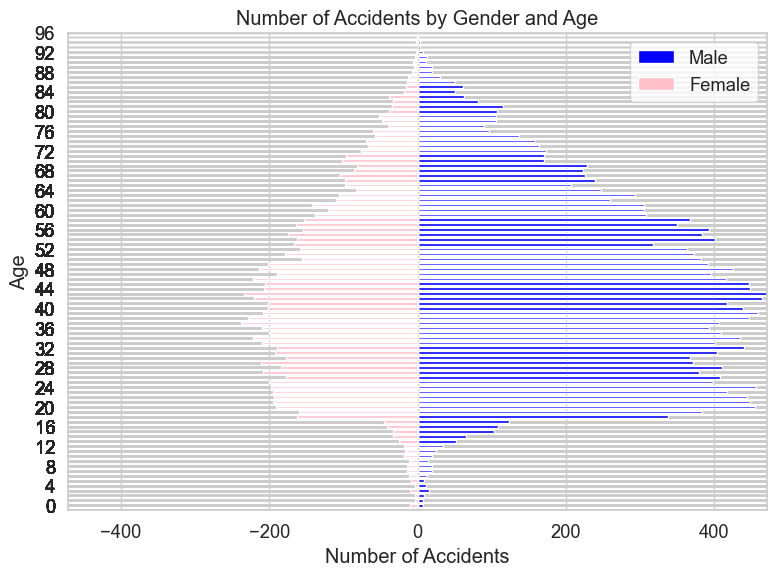

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the relevant data from Osebe.csv


# Select the relevant columns for analysis (Spol: gender, Starost: age)
data = osebe[['Spol', 'Starost']]

# Group the data by gender and age and calculate the count of accidents for each group
gender_age_analysis = data.groupby(['Spol', 'Starost']).size().reset_index(name='AccidentCount')

# Separate the data for males and females
males = gender_age_analysis[gender_age_analysis['Spol'] == 'MOŠKI']
females = gender_age_analysis[gender_age_analysis['Spol'] == 'ŽENSKI']

# Sort the data by age in descending order
males = males.sort_values('Starost', ascending=False)
females = females.sort_values('Starost', ascending=False)

# Create a pyramid plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the male data on the left side
ax.barh(males['Starost'], males['AccidentCount'], color='blue', align='center', height=0.5, label='Male')

# Plot the female data on the right side (invert the x-values)
ax.barh(females['Starost'], -females['AccidentCount'], color='pink', align='center', height=0.5, label='Female')

# Set the y-axis label and limits
ax.set_ylabel('Age')
ax.set_ylim(min(data['Starost']), max(data['Starost']))
ax.set_yticks(data['Starost'])
ax.set_yticklabels(['' if i % 4 != 0 else str(i) for i in data['Starost']])  # Show every 5th label

# Set the x-axis label and limits
ax.set_xlabel('Number of Accidents')
ax.set_xlim(-max(gender_age_analysis['AccidentCount']), max(gender_age_analysis['AccidentCount']))

# Title and legend
ax.set_title('Number of Accidents by Gender and Age')
ax.legend()

# Display the pyramid chart
plt.tight_layout()
plt.show()


**2. vprašanje: Ali vreme in cestišče vpliva na nesrečo?**

Ali čas dneva in dan v tednu vplivata na število nesreč?

zjutraj: 36.82%
popoldne: 44.86%
zvečer: 20.05%


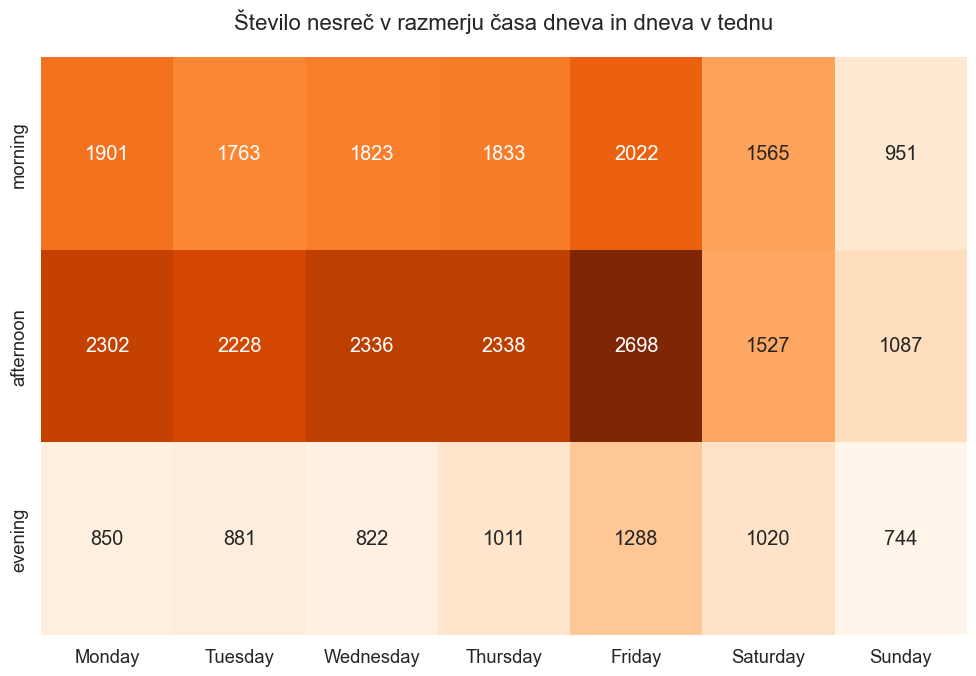

In [25]:
# deklariranje časov dneva
morning_start = pd.to_datetime('00.00', format='%H.%M').time()
morning_end = pd.to_datetime('12.00', format='%H.%M').time()
afternoon_start = pd.to_datetime('12.00', format='%H.%M').time()
afternoon_end = pd.to_datetime('18.00', format='%H.%M').time()
evening_start = pd.to_datetime('18.00', format='%H.%M').time()
evening_end = pd.to_datetime('23.59', format='%H.%M').time()

# popravek ure
cas['UraPN'] = pd.to_datetime(cas['UraPN'].astype(str).apply(lambda x: x + '.00' if len(x) == 2 else x), format='%H.%M').dt.time

# ustvarjenje tabel
morning_df = cas[(cas['UraPN'] >= morning_start) & (cas['UraPN'] <= morning_end)]
afternoon_df = cas[(cas['UraPN'] >= afternoon_start) & (cas['UraPN'] <= afternoon_end)]
evening_df = cas[(cas['UraPN'] >= evening_start) & (cas['UraPN'] <= evening_end)]

# izpis
skupaj= len(cas)
print(f"zjutraj: {len(morning_df)/ skupaj * 100:.2f}%")
print(f"popoldne: {len(afternoon_df)/ skupaj * 100:.2f}%")
print(f"zvečer: {len(evening_df)/ skupaj * 100:.2f}%")


## vizualizacija iz katere vidimo da je največ nesreč popoldne, izstopa pa petek popoldne
cas['time_range'] = pd.cut(cas['UraPN'].apply(lambda x: x.hour*60 + x.minute),
                              bins=[0, morning_end.hour*60 + morning_end.minute, 
                                    afternoon_end.hour*60 + afternoon_end.minute, 
                                    1440],
                              labels=['morning', 'afternoon', 'evening'],
                              right=False)

cas['day'] = pd.to_datetime(cas['DatumPN'], format='%d.%m.%Y').dt.day_name()


heatmap_df = cas.pivot_table(index='time_range', columns='day', values='UraPN', aggfunc=len)
heatmap_df = heatmap_df.reindex(['morning', 'afternoon', 'evening'], axis=0)
heatmap_df = heatmap_df.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], axis=1)

sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(heatmap_df, cmap='Oranges', annot=True, fmt='d', cbar=False, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Število nesreč v razmerju časa dneva in dneva v tednu', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

Ali nekateri dnevi npr. petek, sobota izstopajo z alkoholom?

In [26]:
# mejbi todo

V katerem letnem času je največ nesreč? ali na le te vpliva vreme?

Accident Statistics by Season:
Autumn: 8990 accidents (27.25%)
Summer: 8814 accidents (26.72%)
Spring: 8253 accidents (25.02%)
Winter: 6933 accidents (21.02%)


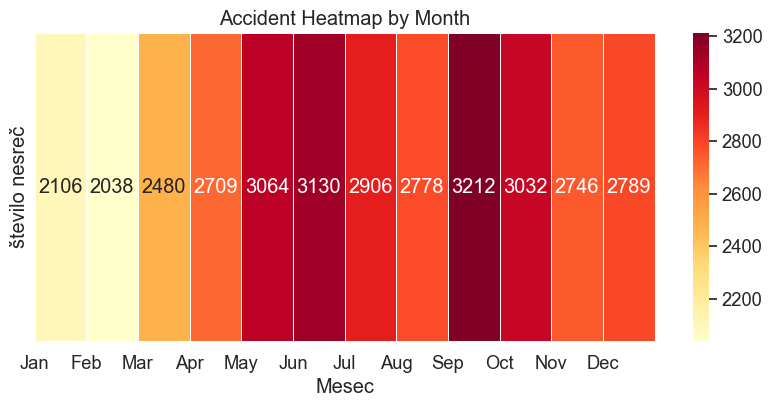

In [27]:
cas['DatumPN'] = pd.to_datetime(cas['DatumPN'], format='%d.%m.%Y')

cas['Month'] = cas['DatumPN'].dt.month

seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11]
}

# Assign seasons to each month
cas['Season'] = cas['Month'].apply(lambda x: next(season for season, months in seasons.items() if x in months))

accidents_per_season = cas['Season'].value_counts()

# Calculate the percentage of accidents for each season
accidents_percentage = (accidents_per_season / len(cas)) * 100

print("Accident Statistics by Season:")
for season in accidents_per_season.index:
    accident_count = accidents_per_season[season]
    accident_percentage = accidents_percentage[season]
    print(f"{season}: {accident_count} accidents ({accident_percentage:.2f}%)")

accidents_by_month = cas['Month'].value_counts().sort_index()
accidents_matrix = accidents_by_month.values.reshape(1, -1) # type: ignore

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(10, 4))
sns.heatmap(accidents_matrix, cmap='YlOrRd', annot=True, fmt='d', linewidths=0.5, cbar=True) # type: ignore

plt.title("Accident Heatmap by Month")
plt.xlabel("Mesec")
plt.ylabel("število nesreč")

plt.xticks(range(len(month_labels)), month_labels)
plt.yticks([])
plt.show()

Katere nesreče so najbolj pogoste v vremenih kot sta sneg in megla? Kakšni vzroki nesreč so najbolj pogosti?

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

merged_df = nesreca.merge(faktor_cest, on='ZaporednaStevilkaOsebeVPN')

grouped_df = merged_df.groupby(['VremenskeOkoliscine', 'VzrokNesrece']).size().reset_index(name='Count')

sorted_df = grouped_df.sort_values(['VremenskeOkoliscine', 'Count'], ascending=[True, False])

top_causes_by_weather = sorted_df.groupby('VremenskeOkoliscine').head(3)

# Normalize the data
normalized_df = top_causes_by_weather.copy()
normalized_df['NormalizedCount'] = normalized_df.groupby('VremenskeOkoliscine')['Count'].apply(lambda x: x / x.sum())

# Plot the data
plt.figure(figsize=(10, 6))
for weather, data in normalized_df.groupby('VzrokNesrece'):
    plt.bar(data['VremenskeOkoliscine'], data['NormalizedCount'], label=weather)
plt.xticks(rotation=45)
plt.xlabel('Accident Cause')
plt.ylabel('Normalized Count')
plt.title('Top 3 Accident Causes for Each Weather Condition (Normalized)')
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\tilen\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\frame.py", line 11615, in _reindex_for_setitem
    reindexed_value = value.reindex(index)._values
                      ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tilen\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\series.py", line 4914, in reindex
    return super().reindex(
           ^^^^^^^^^^^^^^^^
  File "C:\Users\tilen\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\generic.py", line 5360, in reindex
    return self._reindex_axes(
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tilen\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\generic.py", line 5375, in _reindex_axes
    new_index, indexer = ax.reindex(
                         ^^^^^^^^^^^
  File "C:\Users\tilen\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py", line 4278, in reindex
    target = self

Kateri tipi ceste so najbolj nevarni? (suha proti mokra)

In [30]:
df = pd.merge(faktor_cest, nesreca[['ZaporednaStevilkaOsebeVPN', 'TipNesrece']], on='ZaporednaStevilkaOsebeVPN')

df = df[['StanjeVozisca', 'TipNesrece']]

# odstrani vozisca in tipe nesrec v neznanem stanju
df = df.loc[df['StanjeVozisca'] != 'OSTALO']
df = df.loc[df['TipNesrece'] != 'OSTALO']
# print("Unique values in StanjeVozisca:", df['StanjeVozisca'].unique())
# print("\nUnique values in TipNesrece:", df['TipNesrece'].unique())

# obdrži vrstice s StanjeVozisca = SUHO, ostale pa preimenuj v DRUGACNO
df.loc[df['StanjeVozisca'] != 'SUHO', 'StanjeVozisca'] = 'DRUGACNO'

df['TipNesrece_new'] = 'SE PREMIKA'
mask = (df['TipNesrece'] == 'TRČENJE V STOJEČE / PARKIRANO VOZILO') | (df['TipNesrece'] == 'TRČENJE V OBJEKT')
df.loc[mask, 'TipNesrece_new'] = 'STACIONAREN'

mask = (df['TipNesrece'] == 'BOČNO TRČENJE') | (df['TipNesrece'] == 'OPLAŽENJE') | (df['TipNesrece'] == 'NALETNO TRČENJE') | (df['TipNesrece'] == 'POVOŽENJE ŽIVALI') | (df['TipNesrece'] == 'POVOŽENJE PEŠCA') | (df['TipNesrece'] == 'ČELNO TRČENJE')
df.loc[mask, 'TipNesrece_new'] = 'SE PREMIKA'

df.drop(columns=['TipNesrece'], inplace=True)
df.rename(columns={'TipNesrece_new': 'TipNesrece'}, inplace=True)

# print("Unique values in StanjeVozisca:", df['StanjeVozisca'].unique())
# print("Unique values in TipNesrece:", df['TipNesrece'].unique())

suhoSVC = df['StanjeVozisca'].value_counts()['SUHO']
drugacnoSVC = df['StanjeVozisca'].value_counts()['DRUGACNO']
sepremikaTNC = df['TipNesrece'].value_counts()['SE PREMIKA']
stacionarenTNC = df['TipNesrece'].value_counts()['STACIONAREN']

print("STACIONAREN OBJEKT:", stacionarenTNC)
# print("PREMIKAJOČ OBJEKT:", sepremikaTNC)
print("SUHA CESTA:", suhoSVC)
print("MOKRA CESTA:", drugacnoSVC)


ms = len(df[(df['StanjeVozisca'] == 'DRUGACNO') & (df['TipNesrece'] == 'STACIONAREN')])
ss = len(df[(df['StanjeVozisca'] == 'SUHO') & (df['TipNesrece'] == 'STACIONAREN')])
# mp = len(df[(df['StanjeVozisca'] == 'DRUGACNO') & (df['TipNesrece'] == 'SE PREMIKA')])
# sp = len(df[(df['StanjeVozisca'] == 'SUHO') & (df['TipNesrece'] == 'SE PREMIKA')])

print("\nSTACIONAREN OBJEKT, SUHA CESTA:", ss, "\nSTACIONAREN OBJEKT, MOKRA CESTA:", ms)

r1 = suhoSVC / ss
r2 = drugacnoSVC / ms

# print("\nRazmerje stoji & suha:", r1)
# print("Razmerje stoji & mokra:", r2)

percentage_difference = abs((r1 - r2) / ((r1 + r2) / 2)) * 100

print(f"\nKarambolov v stacionarne objekte (npr. parkiran avto, stavba, itd.) je bilo na mokri (ali poledeneli, poškodovani) cesti {round(percentage_difference, 4)}% več kot karambolov v stacionarne objekte na suhi (nepoškodovani) cesti.")

STACIONAREN OBJEKT: 7158
SUHA CESTA: 22534
MOKRA CESTA: 6749

STACIONAREN OBJEKT, SUHA CESTA: 5444 
STACIONAREN OBJEKT, MOKRA CESTA: 1714

Karambolov v stacionarne objekte (npr. parkiran avto, stavba, itd.) je bilo na mokri (ali poledeneli, poškodovani) cesti 4.9936% več kot karambolov v stacionarne objekte na suhi (nepoškodovani) cesti.


**3. vprašanje? Vozilo in poškodba**

Ali je poškodba odvisna od vozila povzročitelja? 

Kako se razlikujejo poškodbe udeležencev glede na tip udeležbe(pešec, kolesar, motor itd.)? 

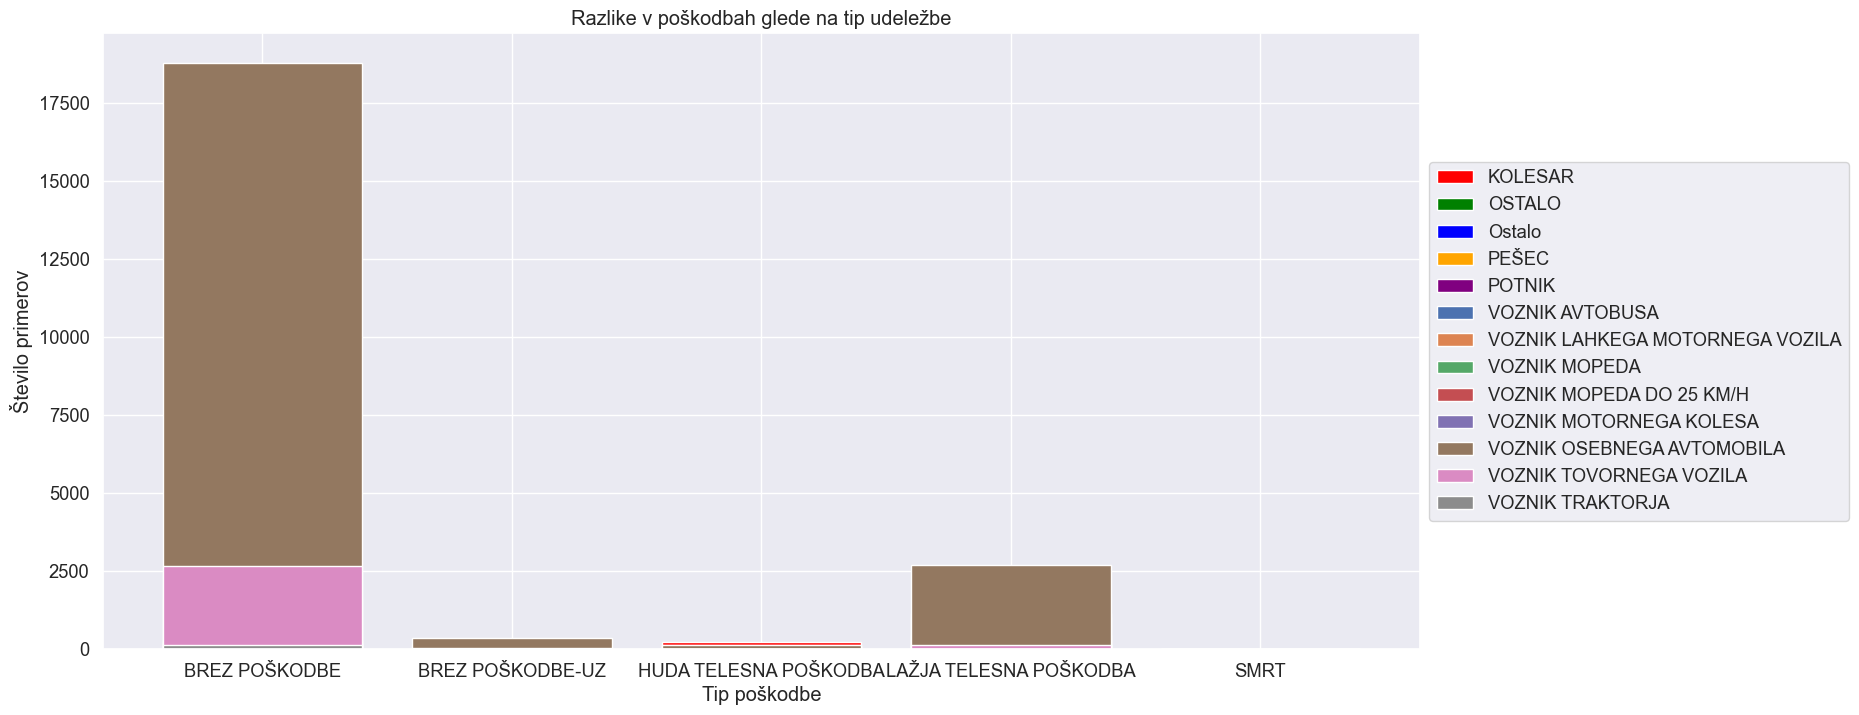

In [31]:
tipi_udelezbe = osebe['VrstaUdelezenca'].value_counts()
min_count = 100
pogoste_vrste = tipi_udelezbe[tipi_udelezbe >= min_count].index
osebe['VrstaUdelezenca'] = np.where(osebe['VrstaUdelezenca'].isin(pogoste_vrste), osebe['VrstaUdelezenca'], 'Ostalo')


poškodbe_udeleženci = osebe.groupby(['VrstaUdelezenca', 'PoskodbaUdelezenca']).size().unstack(fill_value=0)

barve = ['red', 'green', 'blue', 'orange', 'purple']

plt.figure(figsize=(17, 8))
for i, (tip, poškodbe) in enumerate(poškodbe_udeleženci.iterrows()):
    if i < len(barve):
        plt.bar(poškodbe.index, poškodbe.values, label=tip, color=barve[i])
    else:
        plt.bar(poškodbe.index, poškodbe.values, label=tip)

plt.title('Razlike v poškodbah glede na tip udeležbe')
plt.xlabel('Tip poškodbe')
plt.ylabel('Število primerov')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Kateri so najpogostejši udeleženci nesreče? 

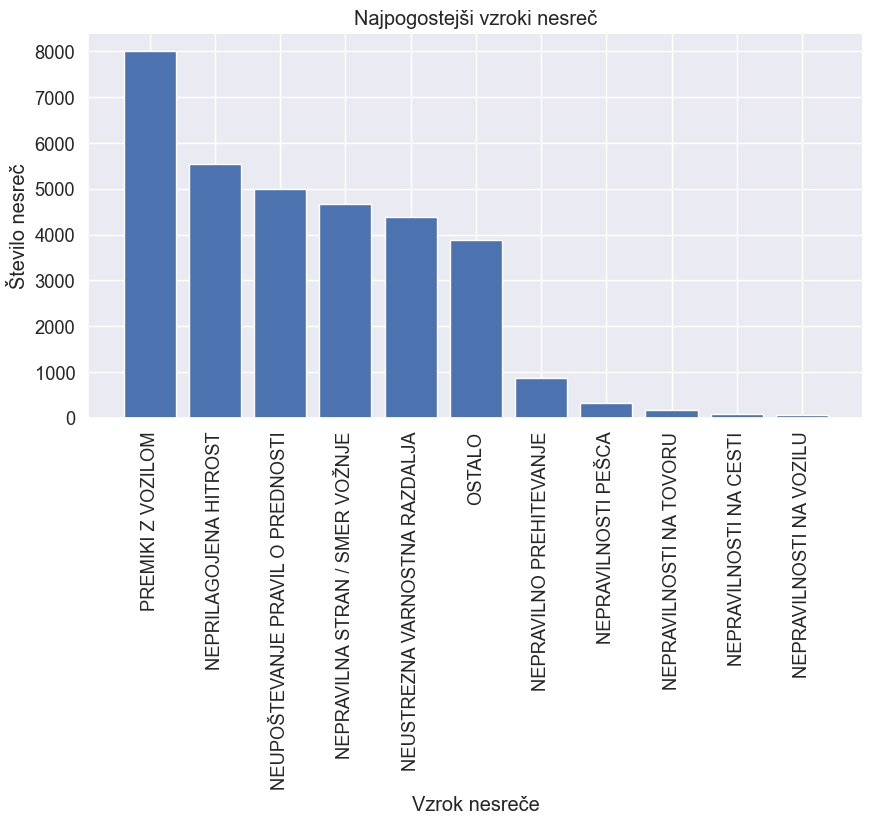

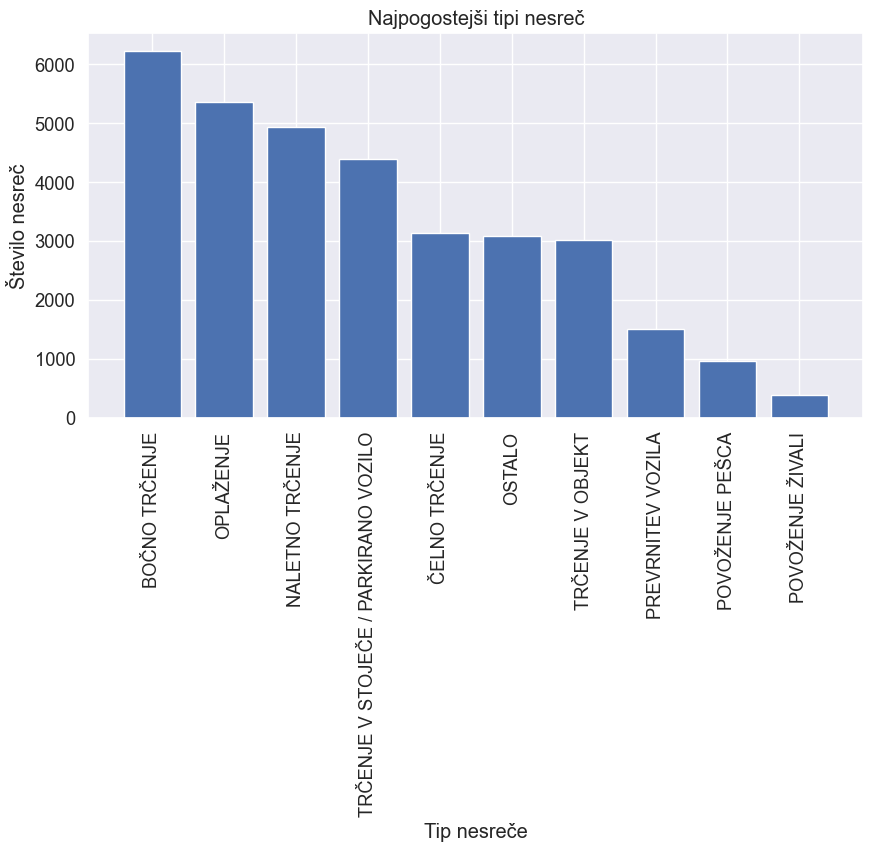

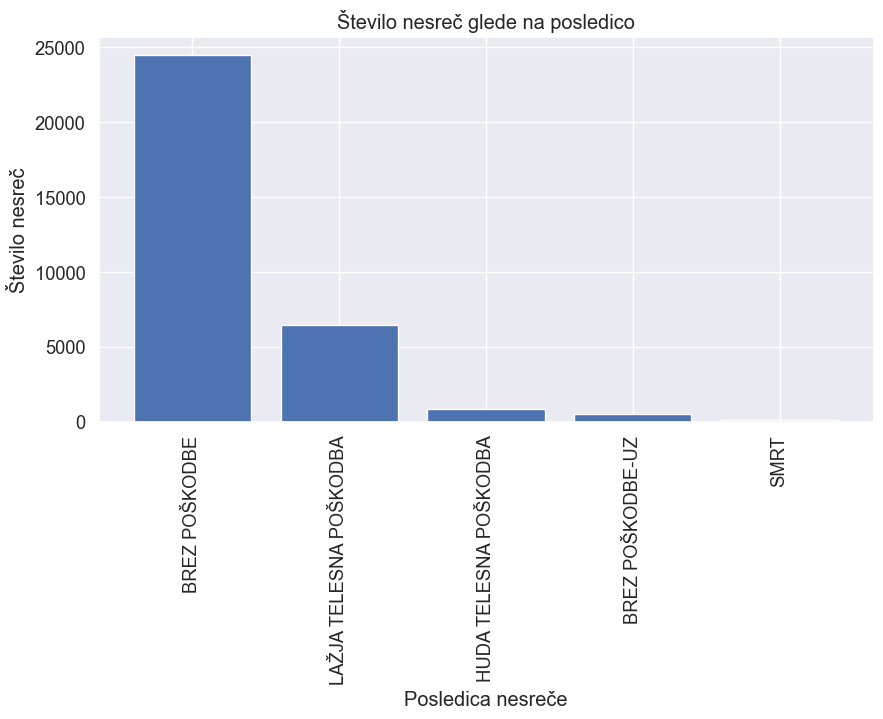

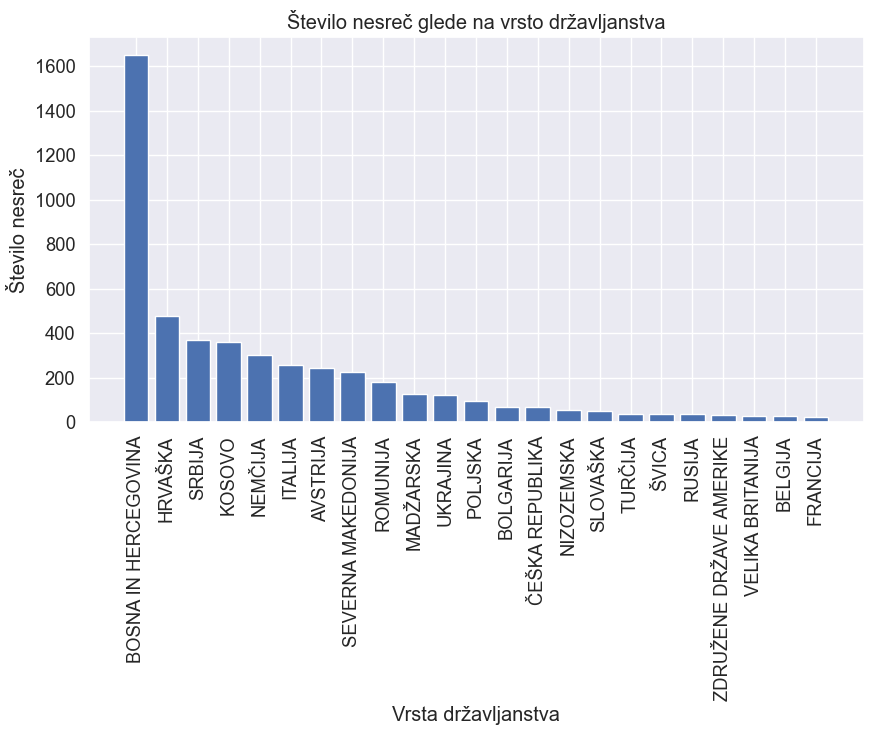

In [32]:
df = pd.read_csv('./baze/pn2022.csv', sep=';', decimal=',', encoding='utf-8')

vzroki = df['VzrokNesrece']

st_nesrec_po_vzrokih = vzroki.value_counts()

plt.figure(figsize=(10,5))
plt.bar(st_nesrec_po_vzrokih.index, st_nesrec_po_vzrokih.values)
plt.xticks(rotation=90)
plt.xlabel('Vzrok nesreče')
plt.ylabel('Število nesreč')
plt.title('Najpogostejši vzroki nesreč')
plt.show()


tipi = df['TipNesrece']

st_nesrec_po_tipih = tipi.value_counts()

plt.figure(figsize=(10,5))
plt.bar(st_nesrec_po_tipih.index, st_nesrec_po_tipih.values)
plt.xticks(rotation=90)
plt.xlabel('Tip nesreče')
plt.ylabel('Število nesreč')
plt.title('Najpogostejši tipi nesreč')
plt.show()

posledice = df['PoskodbaUdelezenca']


st_nesrec_po_posledicah = posledice.value_counts()

plt.figure(figsize=(10,5))
plt.bar(st_nesrec_po_posledicah.index, st_nesrec_po_posledicah.values)
plt.title("Število nesreč glede na posledico")
plt.xticks(rotation=90)
plt.xlabel("Posledica nesreče")
plt.ylabel("Število nesreč")
plt.show()


drzavljanstvo = df['Drzavljanstvo']
st_nesrec_po_drzavljanstvu = drzavljanstvo.value_counts().drop('SLOVENIJA').loc[lambda x: x > 20]
plt.figure(figsize=(10,5))
plt.bar(st_nesrec_po_drzavljanstvu.index, st_nesrec_po_drzavljanstvu.values)
plt.title("Število nesreč glede na vrsto državljanstva")
plt.xticks(rotation=90)
plt.xlabel("Vrsta državljanstva")
plt.ylabel("Število nesreč")
plt.show()

Ali lahko napovemo posledico telesne poškodbe glede na druge faktorje nesreče?

In [ ]:
#########################################################
#####                                               #####
#####         RandomForest Prediction Model         #####
#####                                               #####
#########################################################

merged_df = cas.merge(osebe, on='ZaporednaStevilkaOsebeVPN')
merged_df = merged_df.merge(nesreca, on='ZaporednaStevilkaOsebeVPN')
merged_df = merged_df.merge(splosno, on='ZaporednaStevilkaOsebeVPN')
merged_df = merged_df.merge(cesta, on='ZaporednaStevilkaOsebeVPN')
merged_df = merged_df.merge(faktor_cest, on='ZaporednaStevilkaOsebeVPN')
merged_df = merged_df.merge(faktor_oseb, on='ZaporednaStevilkaOsebeVPN')

# print(merged_df.columns)

selected_features = ['UraPN', 'Starost', 'VrstaUdelezenca', 'PoskodbaUdelezenca',
       'MeseciIzpita', 'VzrokNesrece', 'TipNesrece', 'VrstaCesteNaselja',
       'VremenskeOkoliscine', 'StanjePrometa']

target_variable = 'KlasifikacijaNesrece'

X = merged_df[selected_features]
y = merged_df[target_variable]

# Perform  encoding on categorical variables
X_encoded = pd.get_dummies(X, columns=['UraPN', 'Starost', 'VrstaUdelezenca', 'PoskodbaUdelezenca',
       'MeseciIzpita', 'VzrokNesrece', 'TipNesrece', 'VrstaCesteNaselja',
       'VremenskeOkoliscine', 'StanjePrometa'])

# X_encoded = pd.get_dummies(X, columns=['UraPN', 'Starost',
#        'MeseciIzpita', 'VrstaCesteNaselja',
#        'VremenskeOkoliscine', 'StanjePrometa'])

# 'UraPN', 'Starost', 'VrstaUdelezenca',
#        'MeseciIzpita', 'VzrokNesrece', 'TipNesrece', 'VrstaCesteNaselja',
#        'VremenskeOkoliscine', 'StanjePrometa']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", round(accuracy, 3)) #current Accuracy: 0.790845710821461  15.5. 17:40
print("Classification Report:", classification_rep)

Ali uporaba varnostnega pasu vpliva na izid poškodbe?

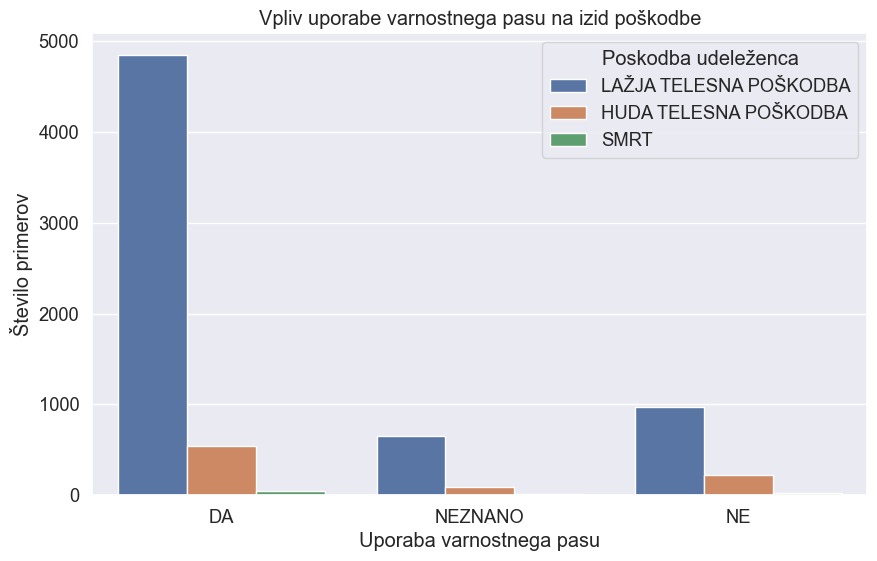

In [33]:
subset = faktor_oseb[['ZaporednaStevilkaOsebeVPN', 'UporabaVarnostnegaPasu', 'VrednostAlkotesta', 'VrednostStrokovnegaPregleda']]
podatki = pd.merge(subset, osebe[['ZaporednaStevilkaOsebeVPN', 'PoskodbaUdelezenca']], on='ZaporednaStevilkaOsebeVPN', how='left')

podatki = podatki.dropna(subset=['PoskodbaUdelezenca'])

podatki = podatki[~podatki['PoskodbaUdelezenca'].isin(['BREZ POŠKODBE', 'BREZ POŠKODBE-UZ'])]

podatki['VrednostAlkotesta'] = podatki['VrednostAlkotesta'].astype(str).str.replace(',', '.').astype(float)
podatki['VrednostStrokovnegaPregleda'] = podatki['VrednostStrokovnegaPregleda'].astype(str).str.replace(',', '.').astype(float)

podatki['VrednostAlkotesta'] = (podatki['VrednostAlkotesta'] - podatki['VrednostAlkotesta'].min()) / (podatki['VrednostAlkotesta'].max() - podatki['VrednostAlkotesta'].min())
podatki['VrednostStrokovnegaPregleda'] = (podatki['VrednostStrokovnegaPregleda'] - podatki['VrednostStrokovnegaPregleda'].min()) / (podatki['VrednostStrokovnegaPregleda'].max() - podatki['VrednostStrokovnegaPregleda'].min())

plt.figure(figsize=(10, 6))
sns.countplot(x='UporabaVarnostnegaPasu', hue='PoskodbaUdelezenca', data=podatki)
plt.title('Vpliv uporabe varnostnega pasu na izid poškodbe')
plt.xlabel('Uporaba varnostnega pasu')
plt.ylabel('Število primerov')
plt.legend(title='Poskodba udeleženca', loc='upper right')
plt.show()